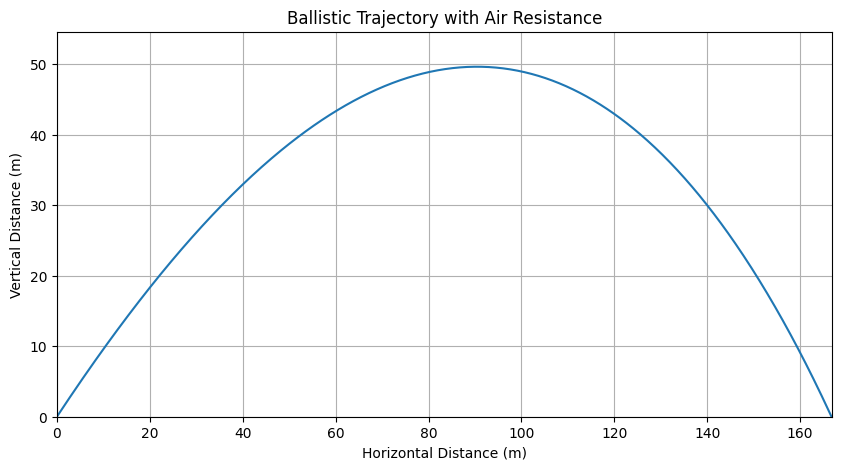

In [6]:
import numpy as np
import matplotlib.pyplot as plt


# Constants
g = 9.81  # gravitational acceleration in m/s^2
rho = 1.225  # air density in kg/m^3
C_d = 0.47  # drag coefficient (for a sphere)
A = 0.01  # cross-sectional area in m^2 (example value)
m = 1.0  # mass of the object in kg (example value)

# Initial conditions
v0 = 50.0  # initial velocity in m/s
angle = 45.0  # launch angle in degrees
angle_rad = np.radians(angle)

# Initial velocity components
vx0 = v0 * np.cos(angle_rad)
vy0 = v0 * np.sin(angle_rad)

# Time settings
dt = 0.01  # time step in seconds
t_max = 10 # maximum time in seconds (arbitrary, should be large enough)

# Initialize arrays to store positions and velocities
times = np.arange(0, t_max, dt)
x = np.zeros_like(times)
y = np.zeros_like(times)
vx = np.zeros_like(times)
vy = np.zeros_like(times)

# Initial positions and velocities
x[0] = 0
y[0] = 0
vx[0] = vx0
vy[0] = vy0

# Simulation loop
for i in range(1, len(times)):
    
    v = np.sqrt(vx[i-1]**2 + vy[i-1]**2)
    
    F_d = 0.5 * C_d * rho * A * v**2
    ax = -F_d * vx[i-1] / (m * v)
    ay = -g - (F_d * vy[i-1] / (m * v))
    
    vx[i] = vx[i-1] + ax * dt
    vy[i] = vy[i-1] + ay * dt
    x[i] = x[i-1] + vx[i] * dt
    y[i] = y[i-1] + vy[i] * dt
    
    # Stop if the projectile hits the ground
    if y[i] < 0:
        x = x[:i+1]
        y = y[:i+1]
        break

# Plotting the trajectory
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.title("Ballistic Trajectory with Air Resistance")
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("Vertical Distance (m)")
plt.grid()
plt.xlim(0, max(x))
plt.ylim(0, max(y) * 1.1)  # Adding a bit of space above the peak
plt.show()

In [ ]:
rows = []

while y >= 0:
    vx_ = f(vx)
    vy_ = f(vy


    rows.append({
        't': t
        'x': x,
        'y': y
        'vx': vx,
        'vy': vy,
    })
            
    vx = vx_
    vy = vy_



# df = pd.DataFrame(rows)
#df.plot('x','y')